In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
pd.set_option('display.max_columns', 100)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS, TSNE
from kneed import KneeLocator

### Task 1 : Data Preparation Pipeline

In [33]:
# Load the prepared bank dataset into a DataFrame
df = pd.read_csv('bank.csv')  # Replace 'prepared_bank_dataset.csv' with your prepared dataset filename


In [34]:
df.describe()  

age       balance          day     duration     campaign  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500    13.851500   292.020500     1.909500   
std      12.724358   3131.224213     9.712189   221.557295     1.378862   
min      18.000000   -980.000000     1.000000     7.000000     1.000000   
25%      32.000000    201.500000     5.000000   146.000000     1.000000   
50%      38.000000    551.000000    12.000000   236.000000     1.000000   
75%      50.000000   1644.500000    23.000000   379.000000     2.000000   
max      93.000000  81204.000000    31.000000  1823.000000    11.000000   

             pdays     previous  
count  2000.000000  2000.000000  
mean    167.896000     2.561500  
std     131.754126     3.400735  
min      -1.000000     0.000000  
25%      75.750000     1.000000  
50%     182.000000     2.000000  
75%     251.000000     3.000000  
max     854.000000    55.000000

In [35]:
categorical_attributes = df.select_dtypes(include='object')
categorical_attributes.describe()

job  marital  education default housing  loan   contact month  \
count         1990     2000       1896    2000    2000  2000      1809  2000   
unique          11        3          3       2       2     2         2    12   
top     management  married  secondary      no      no    no  cellular   feb   
freq           461     1111        995    1985    1037  1750      1663   404   

       poutcome subscribed  
count      1546       2000  
unique        3          2  
top     failure         no  
freq        955       1000

In [36]:
# Define the numerical and categorical column names
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_cols = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month']


In [37]:
## Based on EDA(etity-1), dropping few features and label(subscribed)

df=df.drop(['default','poutcome','subscribed'], axis=1)


In [38]:
df.head()

age          job   marital  education  balance housing loan   contact  \
0  32.0   technician    single   tertiary      392     yes   no  cellular   
1  39.0   technician  divorced  secondary      688     yes  yes  cellular   
2  59.0      retired   married  secondary     1035     yes  yes  cellular   
3  47.0  blue-collar   married  secondary      398     yes  yes  cellular   
4  54.0      retired   married  secondary     1004     yes   no  cellular   

   day month  duration  campaign  pdays  previous  
0    1   apr       957         2    131         2  
1    1   apr       233         2    133         1  
2    1   apr       126         2    239         1  
3    1   apr       274         1    238         2  
4    1   apr       479         1    307         1

#### create pipeline for data preparation

In [39]:
# Numerical transformations
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('outlier_handler', FunctionTransformer(np.log1p))
])

# Categorical transformations
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer for applying transformations to specific columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [40]:
pipe = Pipeline(steps=[
    ('preprocess', preprocessor), 
])

In [41]:
preprocessed_data = pipe.fit(df)['preprocess'].transform(df)

scattered Plot function 

In [42]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

### Task 2: k-Means

In [43]:
scaled_features=df

In [44]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 500,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    pipe = Pipeline(steps=[
    ('preprocess', preprocessor), 
    ('kMeans', cluster.KMeans(n_clusters=k, **kmeans_kwargs))
    ])
    pipe.fit(scaled_features)
    sse.append(pipe['kMeans'].inertia_)

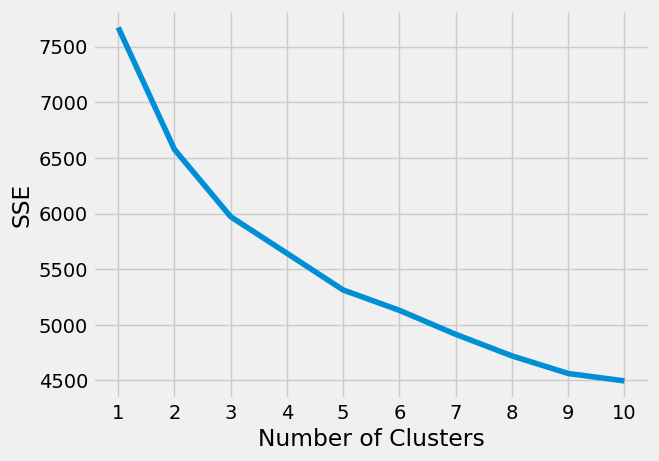

In [45]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [46]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print(f"Best Value of K from elbow method is {kl.elbow}")

Best Value of K from elbow method is 3


In [47]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    pipe = Pipeline(steps=[
    ('preprocess', preprocessor), 
    ('kMeans', cluster.KMeans(n_clusters=k, **kmeans_kwargs))
    ])
    pipe.fit(scaled_features)
    score = silhouette_score(preprocessed_data, pipe['kMeans'].labels_)
    silhouette_coefficients.append(score)

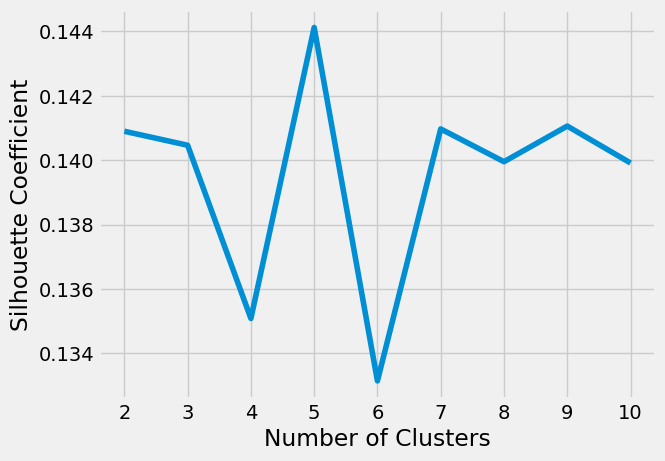

In [48]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Best value of K from Silhouette Coefficient  is 5

Lets start with 3 clusters

In [49]:
k = 3

pipe = Pipeline(steps=[
    ('preprocess', preprocessor), 
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
])

clustering_model = pipe.fit(df)

data_and_centers = np.r_[preprocessed_data,clustering_model['kMeans'].cluster_centers_]

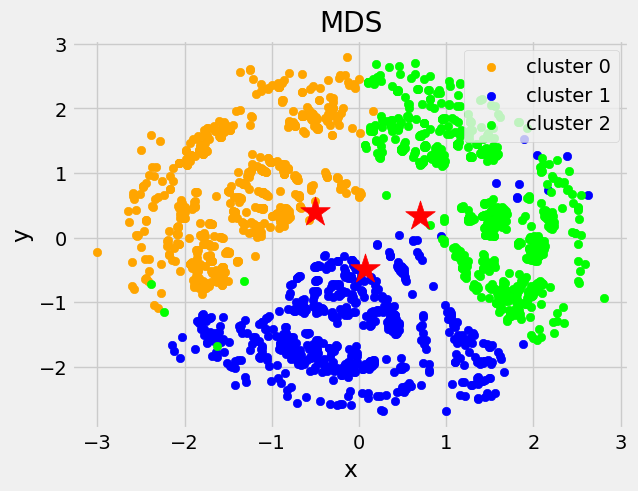

In [50]:
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)


clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

transformation complete


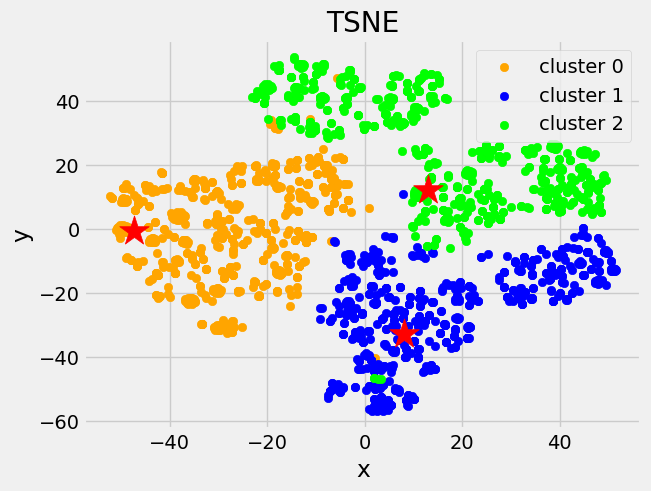

In [51]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")


clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

Now try with 2 clusters

In [52]:
k = 2

pipe = Pipeline(steps=[
    ('preprocess', preprocessor), 
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
])

clustering_model = pipe.fit(df)

data_and_centers = np.r_[preprocessed_data,clustering_model['kMeans'].cluster_centers_]

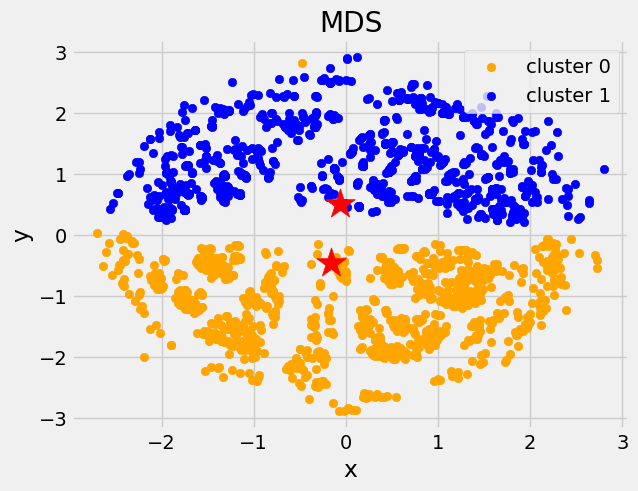

In [53]:
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)


clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

transformation complete


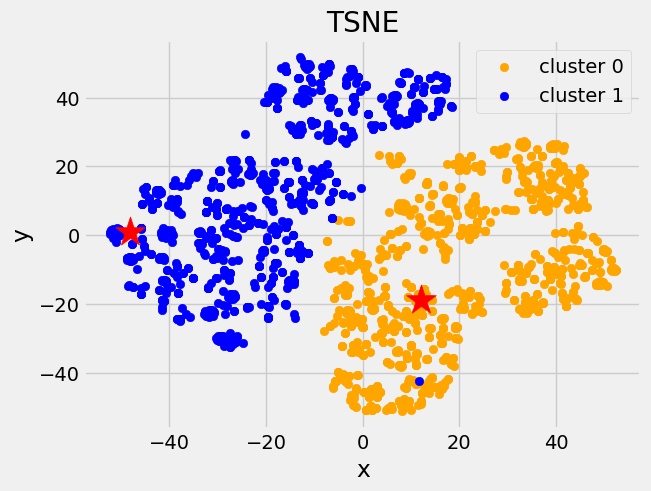

In [54]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")


clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

### Task 3: DBSCAN